In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import random

# Parameters
learning_rate = 0.001
training_epochs = 45 #15
batch_size = 100
display_step = 1

C:\___Anaconda\envs\forTFgpu\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\___Anaconda\envs\forTFgpu\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\___Anaconda\envs\forTFgpu\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\___Anaconda\envs\forTFgpu\lib\site-packages\tensorflow\python\framework\dtypes.py:519: Futu

In [2]:
import csv
import os
import numpy as np

#인코딩중요
#라벨만들기
with open('./trainSet.csv', 'r', encoding='UTF-8-sig') as raw:
    lines = raw.readlines()
data = list(csv.reader(lines))
data = sorted(data, key=lambda x: x[0])

#이름빼기
_Y = [y[1] for y in data]

_Y = np.array(_Y)
_Y = _Y.astype(float) # shape(-1)
_Y = [[1-y, y] for y in _Y] # shape(-1, 2)


#데이터만들기
with open('./features256_exp.csv', 'r', encoding='UTF-8-sig') as raw:
    lines = raw.readlines()
data = list(csv.reader(lines))
data = sorted(data, key=lambda x: x[0])

#이름빼기
_X = [x[1:] for x in data]

_X = np.array(_X)
_X = _X.astype(float) # shape(-1, 1024)

train_X = _X[:8000]
train_Y = _Y[:8000]
test_X = _X[8000:]
test_Y = _Y[8000:]

train_set = tuple(zip(train_X, train_Y))
test_set = tuple(zip(test_X, test_Y))

M_test_X = [t[0] for t in test_set if t[1][1] == 1] # label의 악성이면
M_test_Y = [t[1] for t in test_set if t[1][1] == 1] # label의 악성이면

N_test_X = [t[0] for t in test_set if t[1][0] == 1] # label의 정상이면
N_test_Y = [t[1] for t in test_set if t[1][0] == 1] # label의 정상이면



In [3]:
#fileter_size
s = 5

with tf.device('/gpu:0'):
    X = tf.placeholder(tf.float32, [None, 256])
    X_img = tf.reshape(X, [-1, 16, 16, 1]) # img 28x28x1 (black/white)
    Y = tf.placeholder(tf.float32, [None, 2])
    keep_prob = tf.placeholder(tf.float32)

    #X_img = tf.nn.dropout(X_img, keep_prob=keep_prob)


    # L1 ImgIn shape=(?, 16, 16, 1)
    W1 = tf.Variable(tf.random_normal([s, s, 1, 16], stddev=0.01))
    L1 = tf.nn.conv2d(X_img, W1, strides=[1,1,1,1], padding='SAME')
    L1 = tf.nn.relu(L1)
    L1 = tf.nn.max_pool(L1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    L1 = tf.nn.dropout(L1, keep_prob=keep_prob)
    #    Conv    -> (?, 16, 16, 16)
    #    Pool    -> (?, 8, 8, 16)

    
    # L2 ImgIn shape=(?, 8, 8, 16)
    W2 = tf.Variable(tf.random_normal([s, s, 16, 32], stddev=0.01))
    L2 = tf.nn.conv2d(L1, W2, strides=[1,1,1,1], padding='SAME')
    L2 = tf.nn.relu(L2)
    L2 = tf.nn.max_pool(L2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    L2 = tf.reshape(L1, [-1, 8 * 8 * 16])
    L2 = tf.nn.dropout(L2, keep_prob=keep_prob)
    #    Conv    -> (?, 16, 16, 64)
    #    Pool    -> (?, 8, 8, 64)
    #    Pool    -> (?, 4096)


    W3 = tf.get_variable('W3', shape=[8*8*16, 2], initializer=tf.contrib.layers.xavier_initializer())
    b = tf.Variable(tf.random_normal([2]))
    hypothesis = tf.matmul(L2, W3) + b


    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=hypothesis, labels=Y))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [4]:
# Training
sess = tf.Session()
sess.run(tf.global_variables_initializer())
#sess.run(tf.initialize_all_variables())

# Training cycle
for epoch in range(training_epochs):
    avg_cost = 0
    total_batch = int(len(train_X) / batch_size)

    for i in range(total_batch):
        batch_xs, batch_ys = train_X[i*100:(i+1)*100], train_Y[i*100:(i+1)*100]
        feed_dict = {X: batch_xs, Y: batch_ys, keep_prob: 0.7}
        #feed_dict = {X: batch_xs, Y: batch_ys}
        c, _ = sess.run([cost, optimizer], feed_dict=feed_dict)
        
        avg_cost += c / total_batch #뭉치갯수로 나누기
        
        
    print('Epoch : ', '%04d' % (epoch + 1), 'cost = ', '{:.9f}'.format(avg_cost))


Epoch :  0001 cost =  0.619234120
Epoch :  0002 cost =  0.573284068
Epoch :  0003 cost =  0.552322312
Epoch :  0004 cost =  0.538306959
Epoch :  0005 cost =  0.524522138
Epoch :  0006 cost =  0.508226470
Epoch :  0007 cost =  0.496689177
Epoch :  0008 cost =  0.481721658
Epoch :  0009 cost =  0.473734602
Epoch :  0010 cost =  0.465133891
Epoch :  0011 cost =  0.458632213
Epoch :  0012 cost =  0.449909699
Epoch :  0013 cost =  0.446839606
Epoch :  0014 cost =  0.442812678
Epoch :  0015 cost =  0.433310579
Epoch :  0016 cost =  0.428600574
Epoch :  0017 cost =  0.426928895
Epoch :  0018 cost =  0.422556289
Epoch :  0019 cost =  0.420932001
Epoch :  0020 cost =  0.418568629
Epoch :  0021 cost =  0.413845892
Epoch :  0022 cost =  0.410018187
Epoch :  0023 cost =  0.414221255
Epoch :  0024 cost =  0.405908267
Epoch :  0025 cost =  0.408161195
Epoch :  0026 cost =  0.404351911
Epoch :  0027 cost =  0.400671148
Epoch :  0028 cost =  0.397561625
Epoch :  0029 cost =  0.394537645
Epoch :  0030 

Instructions for updating:
Use `tf.math.argmax` instead
Accuracy :  0.858
정탐율 :  0.981026
오탐율 :  0.5545927
Label: [1]
Prediction: [1]


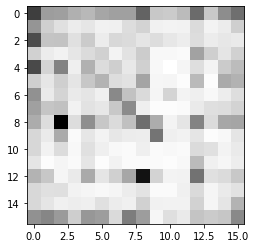

In [5]:
# TEST
is_correct = tf.equal(tf.arg_max(hypothesis, 1), tf.arg_max(Y, 1))
accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))

feed_dict = {X: test_X, Y: test_Y, keep_prob: 1}
print("Accuracy : ", accuracy.eval(session=sess, feed_dict=feed_dict))

feed_dict = {X: M_test_X, Y: M_test_Y, keep_prob: 1}
print("정탐율 : ", accuracy.eval(session=sess, feed_dict=feed_dict))

feed_dict = {X: N_test_X, Y: N_test_Y, keep_prob: 1}
print("오탐율 : ", accuracy.eval(session=sess, feed_dict=feed_dict))




r = random.randint(0, len(test_X) - 1)
print('Label:', sess.run(tf.argmax(test_Y[r:r+1], 1)))

feed_dict = {X: test_X[r:r+1], keep_prob: 1}
print('Prediction:', sess.run(tf.argmax(hypothesis, 1), feed_dict=feed_dict))

plt.imshow(test_X[r:r+1].reshape(16, 16), cmap='Greys', interpolation='nearest')
plt.show()